In [13]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

By now we have seen many examples of situations in which one distribution appears to be quite close to another, such as a population and its sample. The goal of this section is to quantify the difference between two distributions. This will allow our analyses to be based on more than the assessements that we are able to make by eye.

For this, we need a measure of the distance between two distributions. We will develop such a measure in the context of a [study](https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf "ACLU_NC report") conducted in 2010 by the Americal Civil Liberties Union (ACLU) of Northern California. 

The focus of the study was the racial composition of jury panels in Alameda County. A jury panel is a group of people chosen to be prospective jurors; the final trial jury is selected from among them. Jury panels can consist of a few dozen people or several thousand, depending on the trial. By law, a jury panel is supposed to be representative of the community in which the trial is taking place. Section 197 of California's Code of Civil Procedure says, "All persons selected for jury service shall be selected at random, from a source or sources inclusive of a representative cross section of the population of the area served by the court."

The final jury is selected from the panel by deliberate inclusion or exclusion:  the law allows potential jurors to be excused for medical reasons; lawyers on both sides may strike a certain number of potential jurors from the list in what are called "peremptory challenges"; the trial judge might make a selection based on questionnaires filled out by the panel; and so on. But the initial panel is supposed to resemble a random sample of the population of eligible jurors.

The ACLU of Northern California compiled data on the racial composition of the jury panels in 11 felony trials in Alameda County in the years 2009 and 2010. In those panels, the total number of poeple who reported for jury service was 1453. The ACLU gathered demographic data on all of these prosepctive jurors, and compared those data with the composition of all eligible jurors in the county.

The data are tabulated below in a table called ``jury``. For each race, the first value is the percentage of all eligible juror candidates of that race. The second value is the percentage of people of that race among those who appeared for the process of selection into the jury.

In [14]:
jury = Table(["Race", "Eligible", "Panel"]).with_rows([
    ["Asian",  0.15, 0.26],
    ["Black",  0.18, 0.08],
    ["Latino", 0.12, 0.08],
    ["White",  0.54, 0.54],
    ["Other",  0.01, 0.04],
    ])
jury.set_format([1, 2], PercentFormatter(0))

Race,Eligible,Panel
Asian,15%,26%
Black,18%,8%
Latino,12%,8%
White,54%,54%
Other,1%,4%


Some races are overrepresented and some are underrepresented on the jury panels in the study. A bar graph is helpful for visualizing the differences.

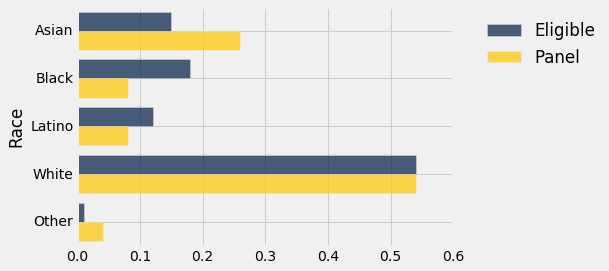

In [15]:
jury.barh('Race')

Total Variation Distance
-----------------------

To measure the difference between the two distributions, we will compute a quantity called the *total variation distance* between them. To compute the total variation distance, take the difference between the two proportions in each category, add up the absolute values of all the differences, and then divide the sum by 2.

Here are the differences and the absolute differences:

In [16]:
jury.append_column("Difference", jury.column("Panel") - jury.column("Eligible"))
jury.append_column("Abs. Difference", np.abs(jury.column("Difference")))
jury.set_format([3, 4], PercentFormatter(0))

Race,Eligible,Panel,Difference,Abs. Difference
Asian,15%,26%,11%,11%
Black,18%,8%,-10%,10%
Latino,12%,8%,-4%,4%
White,54%,54%,0%,0%
Other,1%,4%,3%,3%


And here is the sum of the absolute differences, divided by 2:

In [17]:
sum(jury.column(3)) / 2

1.3877787807814457e-17

The total variation distance between the distribution of eligible jurors and the distribution of the panels is 0.14. Before we examine the numercial value, let us examine the reasons behind the steps in the calculation.

It is quite natural to compute the difference between the proportions in each category. Now take a look at the column ``diff`` and notice that the sum of its entries is 0: the positive entries add up to 0.14, exactly canceling the total of the negative entries which is -0.14. The proportions in each of the two columns ``Panel`` and ``Eligible`` add up to 1, and so the give-and-take between their entries must add up to 0. 

To avoid the cancellation, we drop the negative signs and then add all the entries. But this gives us two times the total of the positive entries (equivalently, two times the total of the negative entries, with the sign removed). So we divide the sum by 2.

We would have obtained the same result by just adding the positive differences. But our method of including all the absolute differences eliminates the need to keep track of which differences are positive and which are not.

The following function computes the total variation distance between two columns of a table.

In [18]:
def total_variation_distance(column, other):
    return sum(np.abs(column - other)) / 2

def table_tvd(table, label, other):
    return total_variation_distance(table.column(label), table.column(other))

table_tvd(jury, 'Eligible', 'Panel')

0.14000000000000001

Are the panels representative of the population?
---------------------------------------------

We will now turn to the numerical value of the total variation distance between the eligible jurors and the panel. How can we interpret the distance of 0.14? To answer this, let us recall that the panels are supposed to be selected at random. It will therefore be informative to compare the value of 0.14 with the total variation distance between the eligible jurors and a randomly selected panel.

To do this, we will employ our skills at simulation. There were 1453 prosepective jurors in the panels in the study. So let us take a random sample of size 1453 from the population of eligible jurors.

[**Technical note.** Random samples of prospective jurors would be selected without replacement. However, when the size of a sample is small relative to the size of the population, sampling without replacement resembles sampling with replacement; the proportions in the population don't change much between draws. The population of eligible jurors in Alameda County is over a million, and compared to that, a sample size of about 1500 is quite small. We will therefore sample with replacement.]

The `np.random.multinomial` function draws a random sample uniformly with replacement from a population whose distribution is categorical.  Specifically, `np.random.multinomial` takes as its input a sample size and an array consisting of the probabilities of choosing different categories. It returns the count of the number of times each category was chosen.

In [19]:
sample_size = 1453

random_panel = np.random.multinomial(sample_size, jury["Eligible"])
random_panel

array([208, 265, 166, 805,   9])

In [20]:
sum(random_panel)

1453

We can compare this distribution with the distribution of eligible jurors, by converting the counts to proportions. To do this, we will divide the counts by the sample size. It is clear from the results that the two distributions are quite similar.

In [21]:
sampled = jury.select(['Race', 'Eligible', 'Panel']).with_column(
    'Random Panel', random_panel / sample_size)
sampled.set_format(3, PercentFormatter(0))

Race,Eligible,Panel,Random Panel
Asian,15%,26%,14%
Black,18%,8%,18%
Latino,12%,8%,11%
White,54%,54%,55%
Other,1%,4%,1%


As always, it helps to visualize. The population and sample are quite similar.

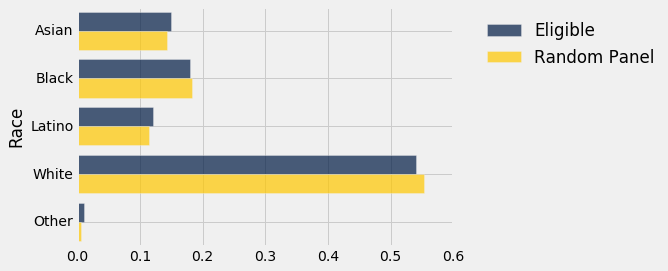

In [22]:
sampled.barh('Race', [1, 3])

When we compare also to the panel, the difference is stark.

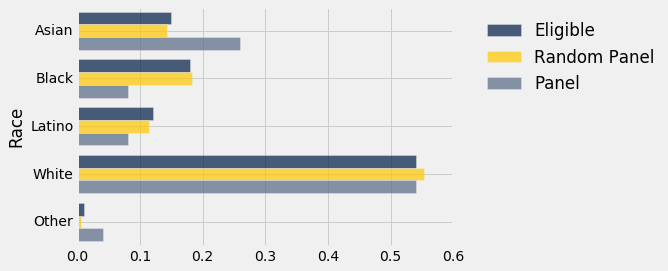

In [23]:
sampled.barh('Race', [1, 3, 2])

The total variation distance between the population distribution and the sample distribution is quite small.

In [24]:
table_tvd(sampled, 'Eligible', 'Random Panel')

0.016407432897453545

Comparing this to the distance of 0.14 for the panel quantifies our observation that the random sample is close to the distribution of eligible jurors, and the panel is relatively far from the distribution of eligible jurors.

However, the distance between the random sample and the eligible jurors depends on the sample; sampling again might give a different result.

### How do random samples differ from the population?

The total variation distance between the distribution of the random sample and the distribution of the eligible jurors is the statistic that we are using to measure the distance between the two distributions. By repeating the process of sampling, we can measure how much the statistic varies across different random samples. The code below computes the empirical distribution of the statistic based on a large number of replications of the sampling process.

In [25]:
# Compute empirical distribution of TVDs

sample_size = 1453
repetitions = 1000
eligible = jury.column('Eligible')
tvds = Table(["TVD from a random sample"])

for i in np.arange(repetitions):
    sample = np.random.multinomial(sample_size, eligible) / sample_size
    tvd = sum(abs(sample - eligible)) / 2
    tvds.append([tvd])

tvds

TVD from a random sample
0.0207571
0.0286098
0.0201721
0.0308672
0.0185134
0.0102546
0.0119133
0.0346731
0.0271576
0.0216862


Each row of the column above contains the total variation distance between a random sample and the population of eligible jurors.

The histogram of this column shows that drawing 1453 jurors at random from the pool of eligible candidates results in a distribution that rarely deviates from the eligible jurors' race distribution by more than 0.05.

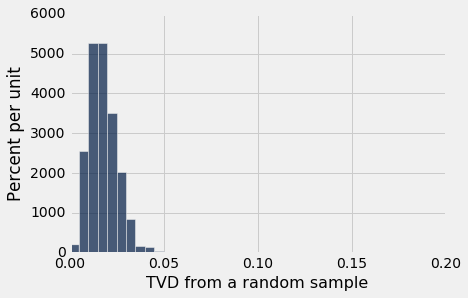

In [26]:
tvds.hist(bins=np.arange(0, 0.2, 0.005))

### How do the panels compare to random samples?

The panels in the study, however, were not quite so similar to the eligible population. The total variation distance between the panels and the population was 0.14, which is far out in the tail of the histogram above. It does not look like a typical distance between a random sample and the eligible population.

Our analysis supports the ACLU's conclusion that the panels were not representative of the population. The ACLU report discusses several reasons for the discrepancies. For example, some minority groups were underrepresented on the records of voter registration and of the Department of Motor Vehicles, the two main sources from which jurors are selected; at the time of the study, the county did not have an effective process for following up on prospective jurors who had been called but had failed to appear; and so on. Whatever the reasons, it seems clear that the composition of the jury panels was different from what we would have expected in a random sample.

A Classical Interlude: the Chi-Squared Statistic
---------------------------------------------

"Do the data look like a random sample?" is a question that has been asked in many contexts for many years. In classical data analysis, the statistic most commonly used in answering this question is called the $\chi^2$ ("chi squared") statistic, and is calculated as follows:

**Step 1.** For each category, define the "expected count" as follows:
$$
\mbox{expected count} ~=~ \mbox{sample size} \times \mbox{proportion in population}
$$
This is the count that you would expect in that category, in a randomly chosen sample.

**Step 2.** For each category, compute
$$
\frac{(\mbox{observed count - expected count})^2}{\mbox{expected count}}
$$

**Step 3.** Add up all the numbers computed in Step 2.

A little algebra shows that this is equivalent to:

**Alternative Method, Step 1.** For each category, compute
$$
\frac{(\mbox{sample proportion - population proportion})^2}{\mbox{population proportion}}
$$

**Alternative Method, Step 2.** Add up all the numbers you computed in the step above, and multiply the sum by the sample size.

It makes sense that the statistic should be based on the difference between proportions in each category, just as the total variation distance is. The remaining steps of the method are not very easy to explain without getting deeper into mathematics.

The reason for choosing this statistic over any other was that statisticians were able to come up a formula for its approximate probability distribution when the sample size is large. The distribution has an impressive name: it is called the *$\chi^2$ distribution with degrees of freedom equal to 4* (one fewer than the number of categories). Data analysts would compute the $\chi^2$ statistic for their sample, and then compare it with tabulated numerical values of the $\chi^2$ distributions.

**Simulating the $\chi^2$ statistic.**

The $\chi^2$ statistic is just a statistic like any other. We can use the computer to simulate its behavior even if we have not studied all the underlying mathematics.

For the panels in the ACLU study, the $\chi^2$ statistic is about 348:

In [27]:
sum(((jury["Panel"] - jury["Eligible"])**2)/jury["Eligible"])*sample_size

348.07422222222226

To generate the empirical distribution of the statistic, all we need is a small modification of the code we used for simulating total variation distance:

In [28]:
# Compute empirical distribution of chi-squared statistic

classical_from_sample = Table(["'Chi-squared' statistic, from a random sample"])
for i in np.arange(repetitions):
    sample = np.random.multinomial(sample_size, eligible)/sample_size
    chisq = sum(((sample - eligible)**2)/eligible)*sample_size
    classical_from_sample.append([chisq])

classical_from_sample

"'Chi-squared' statistic, from a random sample"
5.29816
1.83597
5.03969
4.3795
10.738
4.74311
4.15047
5.83918
9.6604
0.127756


Here is a histogram of the empirical distribution of the $\chi^2$ statistic. The simulated values of $\chi^2$ based on random samples are considerably smaller than the value of 348 that we got from the jury panels.

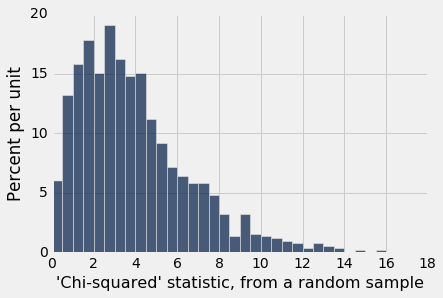

In [29]:
classical_from_sample.hist(bins=np.arange(0, 18, 0.5), normed=True)

In fact, the long run average value of $\chi^2$ statistics is equal to the degrees of freedom. And indeed, the average of the simulated values of $\chi^2$ is close to 4, the degrees of freedom in this case.

In [30]:
np.mean(classical_from_sample.column(0))

3.978631566873136

In this situation, random samples are expected to produce a $\chi^2$ statistic of about 4. The panels, on the other hand, produced a $\chi^2$ statistic of 348. This is yet more confirmation of the conclusion  that the panels do not resemble a random sample from the population of eligible jurors.